In [1]:
import os
os.environ["HF_TOKEN"] = "YOUR_HF_TOKEN"
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

In [2]:
from typing import Optional, Tuple, List
import matplotlib.pylab as plt

import json
import torch
import numpy as np

from data_utils import load_slimpajama, load_hex_phi, load_lmsys
from analyzer import DriftingAnalyzer

/home/jovyan/.mlspace/envs/sparsify/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_mse_fvu_intersection(
    mse: List[float],
    fvu: List[float],
    feature_intersection_ratio: List[float],
    mse_threshold: Optional[float] = None,
    fvu_threshold: Optional[float] = None,
    figsize: Tuple[float, float] = (12, 8),
    ylabel: str = 'FVU',
    point_size: int = 20,
    alpha: float = 0.6,
    colormap: str = 'RdYlGn_r',
    title: Optional[str] = None
) -> plt.Figure:
    mse = np.array(mse)
    fvu = np.array(fvu)
    intersection = np.array(feature_intersection_ratio)
    
    # Set thresholds if not provided
    if mse_threshold is None:
        mse_threshold = np.percentile(mse, 70)
    if fvu_threshold is None:
        fvu_threshold = np.percentile(fvu, 30)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    scatter = ax.scatter(
        mse, 
        fvu, 
        c=intersection,
        s=point_size,
        alpha=alpha,
        cmap=colormap,
        vmin=0,
        vmax=1,
        edgecolors='none'
    )
    
    ax.axvline(x=mse_threshold, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    ax.axhline(y=fvu_threshold, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    n_total = len(mse)
    low_mse_low_fvu = np.sum((mse <= mse_threshold) & (fvu <= fvu_threshold))
    low_mse_high_fvu = np.sum((mse <= mse_threshold) & (fvu > fvu_threshold))
    high_mse_low_fvu = np.sum((mse > mse_threshold) & (fvu <= fvu_threshold))
    high_mse_high_fvu = np.sum((mse > mse_threshold) & (fvu > fvu_threshold))
    
    pct_low_mse_low_fvu = 100 * low_mse_low_fvu / n_total
    pct_low_mse_high_fvu = 100 * low_mse_high_fvu / n_total
    pct_high_mse_low_fvu = 100 * high_mse_low_fvu / n_total
    pct_high_mse_high_fvu = 100 * high_mse_high_fvu / n_total
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Feature Intersection Ratio', rotation=270, labelpad=20, fontsize=14)
    
    ax.set_xlabel('MSE (Chat vs Base Activations)', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    ax.grid(True, alpha=0.3, linestyle=':')
    
    x_center_left = (xlim[0] + mse_threshold) / 2
    x_center_right = (mse_threshold + xlim[1]) / 2
    y_center_bottom = (ylim[0] + fvu_threshold) / 2
    y_center_top = (fvu_threshold + ylim[1]) / 2

    ax.text(
        x_center_left,
        y_center_top,
        f'{pct_low_mse_high_fvu:.1f}%',
        ha='center',
        va='center',
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.4),
        style='italic'
    )
    
    # Top-right quadrant (high MSE, high FVU)
    ax.text(
        x_center_right,
        y_center_top,
        f'{pct_high_mse_high_fvu:.1f}%',
        ha='center',
        va='center',
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.4),
        style='italic'
    )
    
    # Bottom-left quadrant (low MSE, low FVU)
    ax.text(
        x_center_left,
        y_center_bottom,
        f'{pct_low_mse_low_fvu:.1f}%',
        ha='center',
        va='center',
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.4),
        style='italic'
    )
    
    # Bottom-right quadrant (high MSE, low FVU)
    ax.text(
        x_center_right,
        y_center_bottom,
        f'{pct_high_mse_low_fvu:.1f}%',
        ha='center',
        va='center',
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.4),
        style='italic'
    )
    
    
    plt.tight_layout()
    return fig

In [4]:
# Dataset parameters

MAX_EXAMPLES = 2000
DATASET = "slimpajama"

if DATASET == "slimpajama":
    USE_CHAT_FORMAT = False
else:
    USE_CHAT_FORMAT = True

# Model parameters

CHAT_MODEL_NAME = "google/gemma-2-9b-it"
BASE_MODEL_NAME = "google/gemma-2-9b"
MEAN_NORM = 270.933

# SAE parameters

LAYER = 24
SPARSITY_CUTOFF = 100  # average sparsity as estimated by SAELens
SAE_PATH = "gemma-scope-9b-pt-res-canonical"
SAE_ID = f"layer_{LAYER}/width_131k/canonical"

In [5]:
analyzer = DriftingAnalyzer(
    CHAT_MODEL_NAME,
    BASE_MODEL_NAME,
    SAE_PATH,
    SAE_ID,
    LAYER,
    k=SPARSITY_CUTOFF,
    ap_at_k=50,
    use_chat_format=USE_CHAT_FORMAT
)

Loading chat model: google/gemma-2-9b-it


Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


Loading base model: google/gemma-2-9b


Loading checkpoint shards: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Loading SAE: gemma-scope-9b-pt-res-canonical


In [6]:
if DATASET == "slimpajama":
    conversations = load_slimpajama(max_examples=MAX_EXAMPLES)
elif DATASET == "lmsys":
    conversations = load_lmsys(max_examples=MAX_EXAMPLES)
elif DATASET == "hex_phi":
    # TODO: add filtering for bad aligned
    conversations = load_hex_phi(analyzer.chat_model, analyzer.chat_tokenizer,
                                 max_new_tokens=8, device=analyzer.device)
else:
    raise NotImplementedError

Using the latest cached version of the dataset since DKYoon/SlimPajama-6B couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/jovyan/.cache/huggingface/datasets/DKYoon___slim_pajama-6_b/default/0.0.0/b5f90f419b7489cdba26fdbc8c022fcb5562f968 (last modified on Wed Aug 20 19:32:10 2025).


In [7]:
# adjust the scales

# normalize the saes
scaling_factor = (analyzer.d_in**0.5) / MEAN_NORM
# 1. chat

analyzer.chat_sae.W_enc.data /= scaling_factor
analyzer.chat_sae.W_dec.data *= scaling_factor
analyzer.chat_sae.b_dec.data *= scaling_factor

# 2. base
analyzer.base_sae.W_enc.data /= scaling_factor
analyzer.base_sae.W_dec.data *= scaling_factor
analyzer.base_sae.b_dec.data *= scaling_factor

# normalize the activations
analyzer.estimate_scaling_factor(conversations, model_type='chat')
analyzer.estimate_scaling_factor(conversations, model_type='base')

# For diff-in-means
analyzer.chat_sae.fold_W_dec_norm()
analyzer.base_sae.fold_W_dec_norm()

Estimating norm scaling factor:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating norm scaling factor: 100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]


In [8]:
results = analyzer.analyze_conversations(conversations)

Processing pairs: 100%|██████████| 2000/2000 [43:54<00:00,  1.32s/it] 


#### Analyze the drifting

In [9]:
chat_fvu = torch.tensor(results['chat_fvu'], dtype=torch.float32)
base_fvu = torch.tensor(results['base_fvu'], dtype=torch.float32)
mse = torch.tensor(results['mse'], dtype=torch.float32)
chat_l0 = torch.tensor(results['chat_l0'], dtype=torch.float32)
base_l0 = torch.tensor(results['base_l0'], dtype=torch.float32)
intersection_ratio = torch.tensor(results['feature_intersection_ratio'])

# filter for outliers
q_fvu = torch.quantile(chat_fvu, 0.998)
q_mse = torch.quantile(mse, 0.998)
print(f"fvu diapason = [{chat_fvu.min():.2f}, {q_fvu:.2f}]")
print(f"mse diapason = [{mse.min():.2f}, {q_mse:.2f}]")

inlier_indices = torch.where(torch.logical_and(chat_fvu < q_fvu, mse < q_mse))[0]
print(f"# (fvu & mse) outliers = {len(chat_fvu) - len(inlier_indices)}")

chat_fvu = chat_fvu[inlier_indices].tolist()
base_fvu = base_fvu[inlier_indices].tolist()
mse = mse[inlier_indices].tolist()
intersection_ratio = intersection_ratio[inlier_indices].tolist()

chat_l0 = chat_l0[inlier_indices]
base_l0 = base_l0[inlier_indices]
print(f"Chat average L0 = {int(chat_l0.mean().item())}")
print(f"Base average L0 = {int(base_l0.mean().item())}")

print(f"# of tokens = {len(chat_fvu)}")

fvu diapason = [0.02, 0.45]
mse diapason = [0.01, 1.22]
# (fvu & mse) outliers = 3192
Chat average L0 = 98
Base average L0 = 91
# of tokens = 1365514


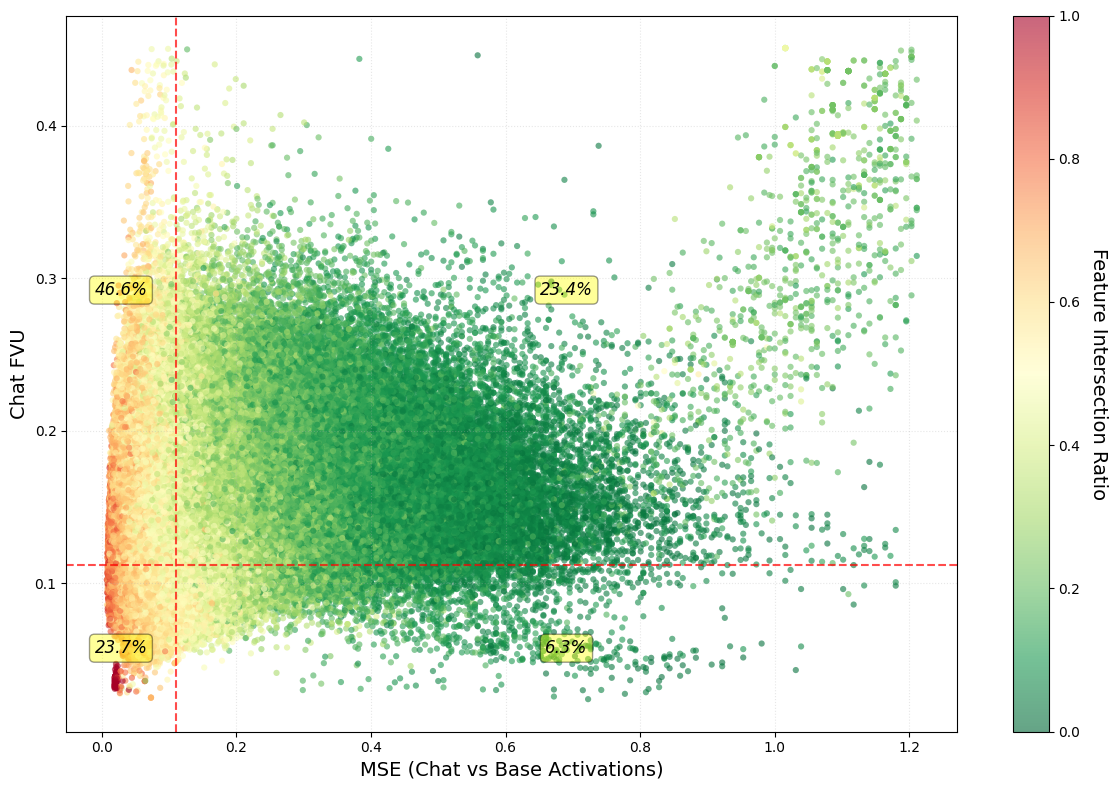

In [10]:
# chat-fvu vs mse

fig = plot_mse_fvu_intersection(
    mse, chat_fvu, intersection_ratio, ylabel='Chat FVU'
)
# fig.savefig("chat-fvu-drifting.png", dpi=300, bbox_inches='tight')

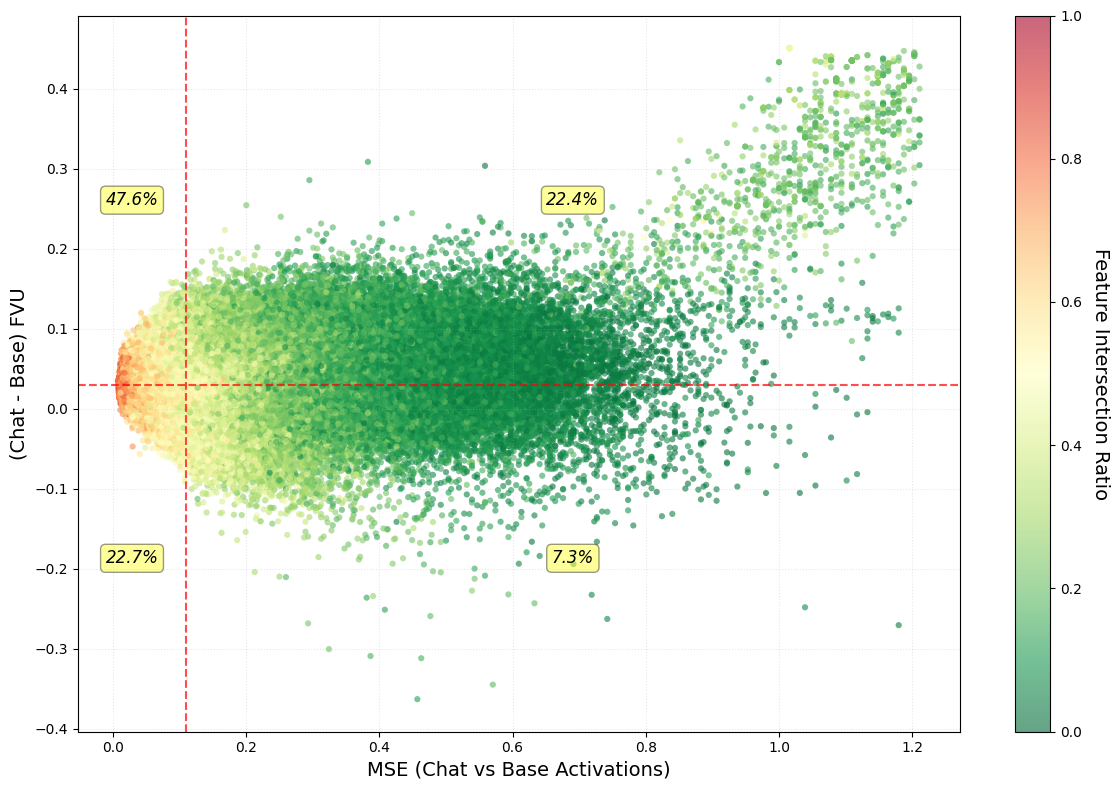

In [11]:
# (chat-fvu - base-fvu) vs mse

fig = plot_mse_fvu_intersection(
    mse, [c - b for c, b in zip(chat_fvu, base_fvu)], intersection_ratio, ylabel='(Chat - Base) FVU'
)
# fig.savefig("diff-fvu-drifting.png", dpi=300, bbox_inches='tight')

#### Analyze the diff-in-means (For HEx-PHI dataset)

NOTE: (Optional) I download feature densities from the neuronpedia and filter the high-frequency (>0.3) features.

Pipeline:
1. Get the mean over all tokens
2. Get top-k feature indices
3. Go to neuronpedia and search for the feature interfaces

In [24]:
diff_in_means = torch.stack(results['feature_diff'])

with open("../feat-distribution/gemma-2-9b/24-gemmascope-res-131k/feature_density.json") as file:
    feature_pdf = json.load(file)
feature_pdf = torch.tensor(feature_pdf, dtype=torch.float32)

# calculate average across per-token average
avg_dim = diff_in_means[:8].mean(dim=0)
avg_dim = torch.where(feature_pdf < 0.3, avg_dim, 0.)
avg_dim.topk(k=20)

torch.return_types.topk(
values=tensor([0.7403, 0.6414, 0.6052, 0.5948, 0.5240, 0.4836, 0.4559, 0.4443, 0.4385,
        0.4231, 0.4203, 0.4126, 0.4126, 0.4065, 0.3988, 0.3903, 0.3830, 0.3826,
        0.3692, 0.3529]),
indices=tensor([ 39088, 105699,  95580,  71882,  53246,  88672, 123477,  86505,  46852,
         89747, 129104,  55680,   1245, 116095, 121510,  16190,  10241,  85951,
         39044, 124047]))